sklearn
https://medium.com/mlreview/topic-modeling-with-scikit-learn-e80d33668730
    
gensim
https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/

In [1]:
import nltk
from nltk import FreqDist
nltk.download('stopwords') # run this one time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prudi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import re
import spacy

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
import os
#os.chdir('C:\\Users\\Administrator\\Desktop\\Data\\reviews_Automotive_5.json')
os.chdir('C:\\Users\\prudi\\Desktop\\Data Sets\\amazon-fine-food-reviews')
#df = pd.read_json('Reviews.json', lines=True)
df=pd.read_csv('Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


Data Preprocessing
Data preprocessing and cleaning is an important step before any text mining task, in this step, we will remove the punctuations, stopwords and normalize the reviews as much as possible. After every preprocessing step, it is a good practice to check the most frequent words in the data. Therefore, let’s define a function that would plot a bar graph of n most frequent words in the data.

In [7]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

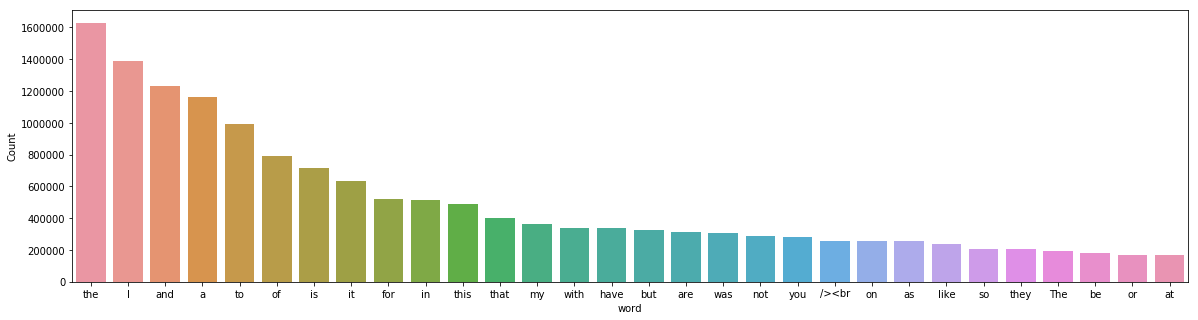

In [9]:
freq_words(df['Text'])

In [10]:
df['Text'] = df['Text'].str.replace("[^a-zA-Z#]", " ")

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [13]:
# function to remove stopwords
def remove_stopwords(rev):
    rev_new = " ".join([i for i in rev if i not in stop_words])
    return rev_new

# remove short words (length < 3)
df['Text'] = df['Text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['Text']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

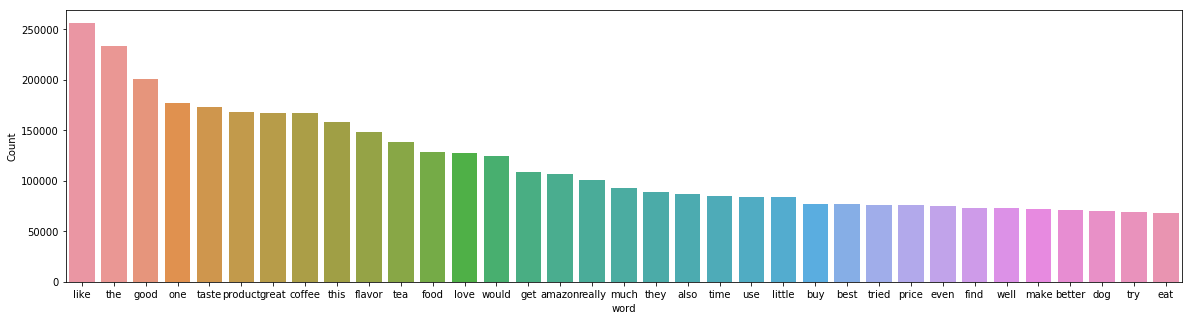

In [14]:
freq_words(reviews, 35)

In [16]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [17]:
def lemmatization(texts, tags=['NOUN', 'ADJ']): # filter noun and adjective
       output = []
       for sent in texts:
             doc = nlp(" ".join(sent)) 
             output.append([token.lemma_ for token in doc if token.pos_ in tags])
       return output

In [18]:
import pandas as pd
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['product', 'arrived', 'labeled', 'jumbo', 'salted', 'peanuts', 'peanuts', 'actually', 'small', 'sized', 'unsalted', 'not', 'sure', 'error', 'vendor', 'intended', 'represent', 'product', 'jumbo']


In [19]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

KeyboardInterrupt: 

In [ ]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

In [ ]:
dictionary = corpora.Dictionary(reviews_2)

In [24]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [31]:
LDA = gensim.models.ldamodel.LdaModel

In [32]:
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

KeyboardInterrupt: 

In [ ]:
lda_model.print_topics()

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

Using SKLEARN

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = len(reviews_2)

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['reviews'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(df['reviews'])
tf_feature_names = tf_vectorizer.get_feature_names()

print(tf_feature_names)

In [39]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)


In [43]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ('Topic %d:' % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
car wash clean clay new stuff dirt bucket paint mitt
Topic 1:
battery charger tender charge motorcycle unit power cable winter plug
Topic 2:
filter air cabin fram oem wrench fit nut dealer amazon
Topic 3:
light bright white night power dome blue interior fog switch
Topic 4:
wiper blade windshield rain bosch streak arm anco snow old
Topic 5:
tire compressor shine spare air slime flat rim truck applicator
Topic 6:
gauge pressure air accurate valve digital psi stem reading compressor
Topic 7:
great price stuff item love quality job quick jeep value
Topic 8:
good price quality job amazon high deal item value brand
Topic 9:
easy install use jeep minute wrangler installation instruction simple quick
Topic 10:
product meguiar bottle result use happy excellent griot mother love
Topic 11:
oil change engine synthetic mile drain royal purple pan transmission
Topic 12:
wheel brush clean dust brake chock bristle soft job rim
Topic 13:
towel microfiber dry soft cloth absorbent water wash pl

NameError: name 'lda' is not defined